# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import numpy as np
import zipfile

# [Already done] Compress original raw data into zip

In [2]:
df = pd.read_excel('raw/donneestrafic-2023.xlsx')

In [3]:
# Save DataFrame to CSV and compress into ZIP
import os
def compress_dataframe_to_zip(dataframe, csv_filename, zip_filename):
    # Save DataFrame to a CSV file
    dataframe.to_csv(csv_filename, index=False)
    
    # Create a ZIP archive and add the CSV file
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(csv_filename)
    
    # Remove the temporary CSV file
    os.remove(csv_filename)
    print(f'DataFrame successfully compressed into {zip_filename}')

In [4]:
# File paths
csv_filename = 'donneestrafic-2023.csv'  # CSV filename
zip_filename = 'donneestrafic-2023.zip'  # ZIP archive filename

# Use the function
compress_dataframe_to_zip(df, csv_filename, zip_filename)

DataFrame successfully compressed into donneestrafic-2023.zip


# Read data

In [2]:
# Open the gzip-compressed file
filename = 'donneestrafic-2023'

with zipfile.ZipFile(f'raw/{filename}.zip', 'r') as z:
    with z.open(f'{filename}.csv') as f :
        df = pd.read_csv(f)

In [3]:
df.columns

Index(['POSTE_ID', 'DATECOM', 'DIRECTION', 'VEHICULE', 'P00_01', 'P01_02',
       'P02_03', 'P03_04', 'P04_05', 'P05_06', 'P06_07', 'P07_08', 'P08_09',
       'P09_10', 'P10_11', 'P11_12', 'P12_13', 'P13_14', 'P14_15', 'P15_16',
       'P16_17', 'P17_18', 'P18_19', 'P19_20', 'P20_21', 'P21_22', 'P22_23',
       'P23_24', 'SUM_TRAF', 'LOCALITE', 'ROUTE', 'SENS', 'D1', 'D2',
       'COORD_X', 'COORD_Y'],
      dtype='object')

In [4]:
df.VEHICULE.unique()

array(['C', 'U', 'V'], dtype=object)

In [5]:
df.DIRECTION.value_counts()
# 3 means both direction
# For each pose ID we mainly have 2 directions and the sum of them

DIRECTION
1    279663
2    277909
3    277401
Name: count, dtype: int64

In [6]:
for k in df.POSTE_ID.unique():
    if 3 not in df[df.POSTE_ID == k].DIRECTION.values :
        print(k)

In [7]:
# Directions share the same geometry
df[(df.POSTE_ID== 1) & (df.DATECOM == '2023-01-01') & (df.VEHICULE=='U')]

,POSTE_ID,DATECOM,DIRECTION,VEHICULE,P00_01,P01_02,P02_03,P03_04,P04_05,P05_06,...,P22_23,P23_24,SUM_TRAF,LOCALITE,ROUTE,SENS,D1,D2,COORD_X,COORD_Y
1,1,2023-01-01,1,U,2,6,4,1,1,2,...,0,2,108,CLEMENCY,CR101,Belgique vers Clemency,Belgique,Clemency,58304.0,73602.0
4,1,2023-01-01,2,U,6,7,6,3,3,1,...,5,1,124,CLEMENCY,CR101,Clemency vers Belgique,Belgique,Clemency,58304.0,73602.0
7,1,2023-01-01,3,U,8,13,10,4,4,3,...,5,3,232,CLEMENCY,CR101,Belgique <-> Clemency deux sens,Belgique,Clemency,58304.0,73602.0


In [8]:
# Understanding columns
df['SUM_TRAF'] == df[['P00_01', 'P01_02',
       'P02_03', 'P03_04', 'P04_05', 'P05_06', 'P06_07', 'P07_08', 'P08_09',
       'P09_10', 'P10_11', 'P11_12', 'P12_13', 'P13_14', 'P14_15', 'P15_16',
       'P16_17', 'P17_18', 'P18_19', 'P19_20', 'P20_21', 'P21_22', 'P22_23',
       'P23_24']].sum(axis = 1)

0         True
1         True
2         True
3         True
4         True
          ... 
834968    True
834969    True
834970    True
834971    True
834972    True
Length: 834973, dtype: bool

In [9]:
df.DATECOM.unique()[:10]

array(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
       '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
       '2023-01-09', '2023-01-10'], dtype=object)

In [10]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from temporal_agg import daily_to_aadt

In [11]:
df.DATECOM = pd.to_datetime(df.DATECOM)

In [38]:
mi = df.set_index(['POSTE_ID', 'DATECOM']).index.drop_duplicates()

In [41]:
# Veify there is no bias in the missing dates (like only weekends)

# Step 1: Extract levels
ids = df.POSTE_ID.unique()
all_dates = pd.date_range('2023-01-01', '2023-12-31')

# Step 2: Find missing dates for each ID
missing_dates_per_id = {}

for id_ in ids:
    present_dates = pd.to_datetime(mi[mi.get_level_values(0) == id_].get_level_values(1).unique())
    missing_dates = all_dates.difference(present_dates)
    if not missing_dates.empty:
        missing_dates_per_id[id_] = missing_dates.weekday

# Now missing_dates_per_id[id] gives the missing dates for that ID

In [42]:
missing_dates_per_id

{1: Index([2, 6, 3, 0, 1, 4], dtype='int32'),
 2: Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
        2, 6, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
        5, 6, 0, 1, 2, 3, 4, 5],
       dtype='int32'),
 3: Index([1, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 6, 6, 0, 1, 2, 6], dtype='int32'),
 5: Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
        2, 6],
       dtype='int32'),
 7: Index([6], dtype='int32'),
 9: Index([6, 2, 2, 6, 5, 6, 3, 6, 3, 6], dtype='int32'),
 10: Index([6, 5, 6, 0, 1, 1, 2, 3, 4, 5, 6, 0], dtype='int32'),
 11: Index([4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
        ...
        1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
       dtype='int32', length=314),
 12: Index([1, 6, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
        5, 6, 0, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
        2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
       dtype='int32'),
 13

In [15]:
all, _ = daily_to_aadt(df[(df.DIRECTION == 3) & (df.VEHICULE == 'U')].set_index(['POSTE_ID', 'DATECOM']), 'POSTE_ID', 'DATECOM', ['SUM_TRAF'])
all.columns = ['AADT', 'AAWT']
trucks, _ = daily_to_aadt(df[(df.DIRECTION == 3) & (df.VEHICULE == 'C')].set_index(['POSTE_ID', 'DATECOM']), 'POSTE_ID', 'DATECOM', ['SUM_TRAF'])
trucks.columns = ['TR_AADT', 'TR_AAWT']

jf = pd.concat([all, trucks], axis = 1)

Daily capture rate is 93.7 %
Daily capture rate is 93.9 %


In [16]:
gdf = df[['POSTE_ID', 'COORD_X', 'COORD_Y', 'ROUTE']].drop_duplicates()

gdf = gpd.GeoDataFrame(
    gdf,
    geometry = gpd.points_from_xy(gdf.COORD_X, gdf.COORD_Y),
    crs = 'epsg:2169'
).to_crs(epsg=4326)

In [17]:
jf = jf.join(
    gdf.set_index('POSTE_ID'),
    how = 'left'
)

In [18]:
jf[jf.ROUTE == 'N6']

,AADT,AAWT,TR_AADT,TR_AAWT,COORD_X,COORD_Y,ROUTE,geometry
POSTE_ID,,,,,,,,
20,7759.474719,8940.334646,281.991573,339.996063,60990.77,80497.30,N6,POINT (5.90485 49.65876)
21,8127.024862,9211.853282,503.428177,627.451737,65806.37,79096.31,N6,POINT (5.97159 49.64629)
413,13469.780282,14899.357143,674.219718,810.507937,70278.65,76882.81,N6,POINT (6.03357 49.62648)
434,12056.668508,13350.096899,940.814917,1127.364341,75939.00,75541.00,N6,POINT (6.11193 49.61448)
435,16224.216901,17812.422925,831.473239,1036.667984,68800.00,77943.00,N6,POINT (6.01308 49.63599)


# Clip it to the city urban area

In [20]:
fua = gpd.read_file('../../assets/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')

In [33]:
mask = fua.to_crs('EPSG:4326').loc[fua.eFUA_name == 'Luxembourg'].geometry.values[0]

In [27]:
jf.shape

(298, 8)

In [28]:
jf = gpd.GeoDataFrame(
    jf, 
    geometry = 'geometry',
    crs = 'epsg:4326'
)

In [29]:
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.ops import transform

def geodesic_point_buffer(lat, lon, m):
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(
        f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(m).simplify(1)  # distance in metres
    # return the simplified geometry bounding polygon
    return transform(tfmr.transform, buf)

(5.800437927246094, 6.503357957149751, 49.382594229389966, 49.951440815599284)

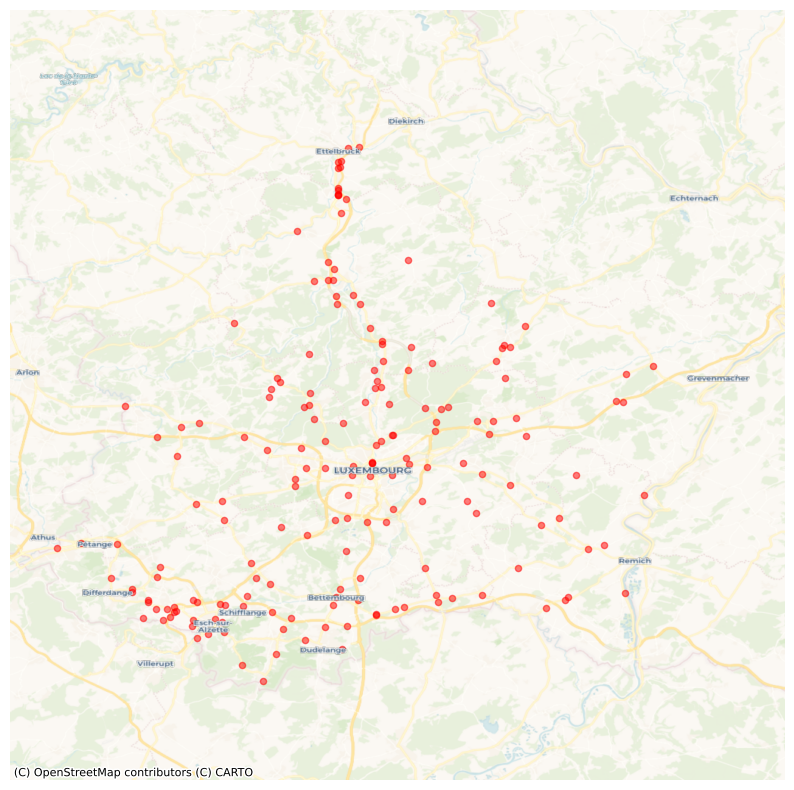

In [35]:
# Clip to Luxembourg radius
city_center = (49.6028557025366,6.130132887146892) # lat, lon


import contextily as cx
#mask = geodesic_point_buffer(*city_center, 10000)

# Plot sensors
ax = jf.clip(mask).plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = jf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = jf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [36]:
jf = jf.clip(mask)

In [37]:
jf.shape

(183, 8)

In [38]:
# Set the oneway argument to False since we account for both directions her
jf['raw_oneway'] = False

# Map matching with OSM

In [39]:
from map_matching_OSM import points_matching

In [40]:
jf = points_matching(jf)

City downloaded


  4%|▍         | 7/183 [00:00<00:06, 27.84it/s]

Value Error - No roads found nearby current index


 15%|█▌        | 28/183 [00:00<00:04, 31.06it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 32%|███▏      | 59/183 [00:02<00:05, 23.02it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 39%|███▉      | 71/183 [00:02<00:05, 21.80it/s]

Value Error - No roads found nearby current index


 55%|█████▍    | 100/183 [00:03<00:02, 27.92it/s]

Value Error - No roads found nearby current index


 62%|██████▏   | 113/183 [00:04<00:02, 31.35it/s]

Value Error - No roads found nearby current index


 66%|██████▌   | 121/183 [00:04<00:02, 24.02it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 71%|███████   | 130/183 [00:05<00:02, 21.90it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 76%|███████▌  | 139/183 [00:05<00:01, 23.03it/s]

Value Error - No roads found nearby current index


 92%|█████████▏| 169/183 [00:06<00:00, 24.81it/s]

Value Error - No roads found nearby current index


 94%|█████████▍| 172/183 [00:06<00:00, 23.45it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|██████████| 183/183 [00:07<00:00, 24.84it/s]

We failed to match 16 sensors
...on a total of 183 sensors


In [41]:
jf.rename(columns = {'ROUTE':'raw_name'}, inplace=True)

In [42]:
jf[['raw_name', 'osm_name', 'osm_type']].drop_duplicates()

,raw_name,osm_name,osm_type
POSTE_ID,,,
1001,N16,Route de Remich,primary
2071,PC07,NaN,NaN
2031,PC03,NaN,primary
1446,A13,Collectrice du Sud,motorway
328,N13B,NaN,trunk
...,...,...,...
705,N7E,NaN,trunk_link
714,B7,Autoroute du Nord,motorway
709,B7,Route du Nord,trunk


# Final saving

In [45]:
from validate_dataset import validate_dataset

jf = validate_dataset(jf)

Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0


In [46]:
jf.to_crs('epsg:4326')[['AADT', 'TR_AADT', 'AAWT', 'TR_AAWT', 'raw_name', 'raw_oneway', 'geometry', 'osm_name', 'osm_type', 'osm_lanes',  'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid']].to_file('treated/Luxembourg_AADT_AAWT_2023.geojson', index=False)

# Understanding data with complementary links in source.txt

In [27]:
# LD AADT -->  Sum  
1398 + 32126

33524

In [28]:
jf.loc[1487]

AADT                                          33524.229412
AAWT                                          37544.029536
TR_AADT                                        1397.864706
TR_AAWT                                        1830.438819
COORD_X                                           80637.51
COORD_Y                                            80313.8
Street_name                                             A7
geometry       POINT (6.176952855042595 49.65740529393917)
osm_name                                 Autoroute du Nord
highway                                           motorway
lanes                                                  2.0
distance                                          6.007792
osmid                                          170225829.0
Name: 1487, dtype: object

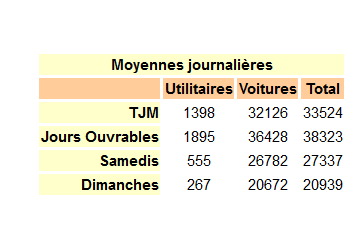